# Background:

We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. From operational standpoint we have been facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

# Data Description:

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers

X1 = my order was delivered on time

X2 = contents of my order was as I expected

X3 = I ordered everything I wanted to order

X4 = I paid a good price for my order

X5 = I am satisfied with my courier

X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

In [1]:
#importing libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
!pip install scikit-learn==1.2.2
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score


In [2]:
df = pd.read_csv('/content/ACME-HappinessSurvey2020.csv')
print(df.head())
print(df.shape)

   Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5
(126, 7)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


# rename the data to a user readable format

In [4]:
# rename columns to a user readable format
old_name = list(df.columns)
new_name = ['happiness', 'order_satisfaction', 'order_completed', 'price_satisfaction',
            'courier_satisfaction', 'app_satisfaction','delivered_time']

df.rename(columns = (dict(zip(old_name, new_name))), inplace = True)
df.head()

,happiness,order_satisfaction,order_completed,price_satisfaction,courier_satisfaction,app_satisfaction,delivered_time
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [5]:
x = df[['delivered_time', 'order_satisfaction', 'order_completed', 'price_satisfaction',
            'courier_satisfaction', 'app_satisfaction']]
display(x.head())
print(x.shape)

,delivered_time,order_satisfaction,order_completed,price_satisfaction,courier_satisfaction,app_satisfaction
0,4,3,3,3,4,2
1,3,3,2,3,5,4
2,5,5,3,3,3,3
3,5,5,4,3,3,3
4,5,5,4,3,3,3


(126, 6)


In [6]:
y = df[['happiness']]
display(y.head())
print(y.shape)

,happiness
0,0
1,0
2,1
3,0
4,0


(126, 1)


# calulating the happy and unhappy cutomers in the given data

In [7]:
# create a function for bootstrapping

def bootstrapping(array, n_sample, n_iters):

    boot = []

    for i in range(n_iters):
        # choose a random index number between 0 to n_sample with replacement
        index = np.random.choice(range(n_sample), replace=True)
        # store value in a temp variable
        sample = array[index]
        # append to list
        boot.append(sample)

    return boot

In [8]:
# split the dataset into happy and unhappy customers
happy_df = df[df.happiness == 1].reset_index(drop=True)
unhappy_df = df[df.happiness == 0].reset_index(drop=True)

print(f' Happy Customers: {len(happy_df)}\n Unhappy Customers: {len(unhappy_df)}')

 Happy Customers: 69
 Unhappy Customers: 57


<ipython-input-9-0f1452d9619f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=df.happiness, palette=custom_palette)
<ipython-input-9-0f1452d9619f>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(['Unhappy', 'Happy'])


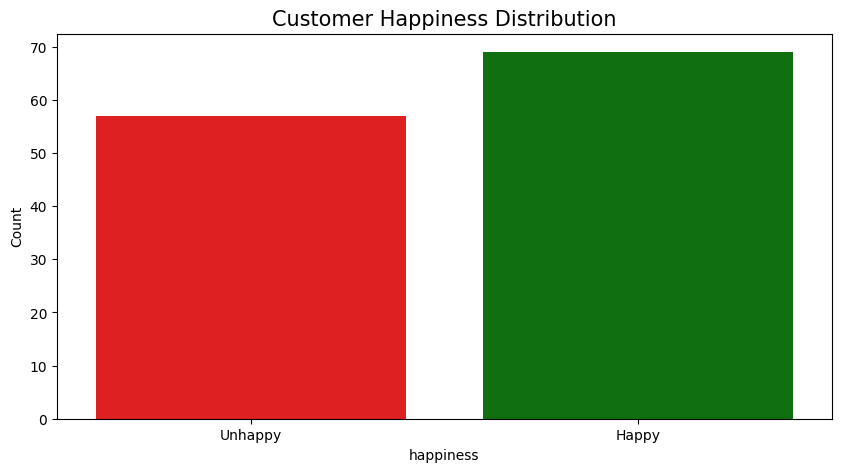

In [9]:
#plot outcome distribution
plt.figure(figsize=(10, 5))
# Define custom colors for 'Happy' and 'Unhappy'
custom_palette = {'0': 'red', '1': 'green'}
ax = sns.countplot(data=df, x=df.happiness, palette=custom_palette)
_ = plt.title('Customer Happiness Distribution', size=15)
# Changed code: updated xtick labels to reflect 0 & 1 mapping
_ = ax.set_xticklabels(['Unhappy', 'Happy'])
_ = plt.ylabel('Count')
_ = plt.show()

# create an array for happy and unhappy values to sample from

In [10]:
# create an array for happy and unhappy values to sample from
happy_array = happy_df.values
unhappy_array = unhappy_df.values
# create a boot to store happy customers at 100 iterations, choosing from the full range of the array
happy_boot = bootstrapping(happy_array, n_sample=len(happy_array), n_iters=100)

# create a boot to store unhappy customers at 100 iterations, choosing from the full range of the array
unhappy_boot = bootstrapping(unhappy_array, n_sample=len(unhappy_array), n_iters=100)

In [11]:
# set the new iteration to 57, the total number of unhappy customers
iters = 57

# set the sample to the length of either happy_boot or unhappy_boot.
# since both are equal it doesn't really matter, but we will test this to make sure.

if len(happy_boot) == len(unhappy_boot):
    sample = len(happy_boot)

# create a new list of happy customers from the boot we created
happy_customers = bootstrapping(happy_boot, sample, iters)

# create a new list of unhappy customers from the boot we created
unhappy_customers = bootstrapping(unhappy_boot, sample, iters)

# confirm length of each new list
print(f' Happy Customers: {len(happy_customers)}\n Unhappy Customers: {len(unhappy_customers)}')

 Happy Customers: 57
 Unhappy Customers: 57


In [12]:
# create a dataframe of happy customers
happy_df = pd.DataFrame(happy_customers, columns=df.columns)

# create a dataframe of unhappy customers
unhappy_df = pd.DataFrame(unhappy_customers, columns=df.columns)

#combine both dataframe into our new dataset
cleaned_df = pd.concat([happy_df, unhappy_df], axis=0).reset_index(drop=True)

<ipython-input-13-e1bbe7580469>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=cleaned_df, x=cleaned_df.happiness,palette=custom_palette)
<ipython-input-13-e1bbe7580469>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(['Unhappy', 'Happy'])


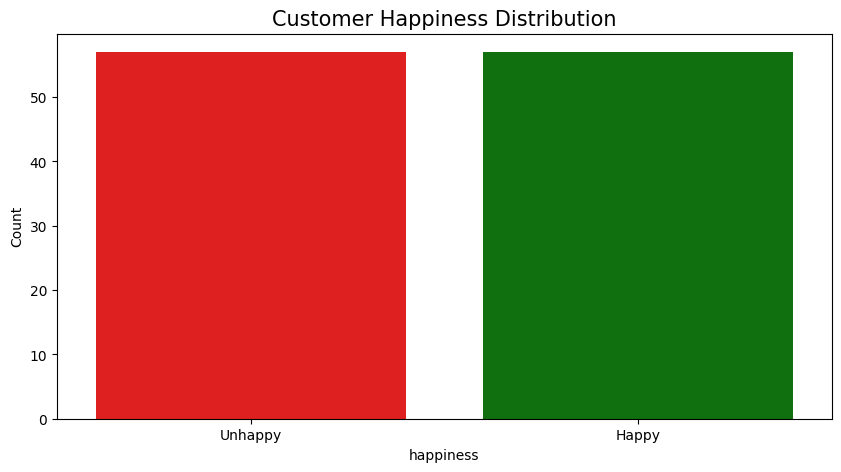

In [13]:
#plot outcome distribution
plt.figure(figsize=(10, 5))
custom_palette = {'0': 'red', '1': 'green'}
ax = sns.countplot(data=cleaned_df, x=cleaned_df.happiness,palette=custom_palette)
_ = plt.title('Customer Happiness Distribution', size=15)
_ = ax.set_xticklabels(['Unhappy', 'Happy'])
_ = plt.ylabel('Count')
_ = plt.show()

In [14]:
x = cleaned_df[['delivered_time', 'order_satisfaction', 'order_completed', 'price_satisfaction',
            'courier_satisfaction', 'app_satisfaction']]
display(x.head())
print(x.shape)

,delivered_time,order_satisfaction,order_completed,price_satisfaction,courier_satisfaction,app_satisfaction
0,4,5,4,5,5,5
1,4,4,3,2,4,3
2,5,5,2,3,5,5
3,4,4,1,3,4,4
4,5,5,1,4,3,4


(114, 6)


In [15]:
y = cleaned_df[['happiness']]
display(y.head())
print(y.shape)

,happiness
0,1
1,1
2,1
3,1
4,1


(114, 1)


# splitting and normalizing data

In [16]:
# split in training 80%, test 20% test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [17]:
# Normalizing data
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train -= mean
x_train /= std

x_test -= mean
x_test /= std

In [18]:
## checking the number of rows and columns in the X_train
print(f"The number of rows in the train data are {x_train.shape[0]}.")
print(f"The number of columns in the train data are {x_train.shape[1]}.")

The number of rows in the train data are 91.
The number of columns in the train data are 6.


In [19]:
## checking the number of rows and columns in the X_train
print(f"The number of rows in the train data are {x_test.shape[0]}.")
print(f"The number of columns in the train data are {x_test.shape[1]}.")

The number of rows in the train data are 23.
The number of columns in the train data are 6.


In [20]:
## checking the number of rows and columns in the X_train
print(f"The number of rows in the train data are {y_train.shape[0]}.")
print(f"The number of columns in the train data are {y_train.shape[1]}.")

The number of rows in the train data are 91.
The number of columns in the train data are 1.


In [21]:
## checking the number of rows and columns in the X_train
print(f"The number of rows in the train data are {y_test.shape[0]}.")
print(f"The number of columns in the train data are {y_test.shape[1]}.")

The number of rows in the train data are 23.
The number of columns in the train data are 1.


# Training a several models
I am suposed to use a hyperparametric tuning for each model as it involves systematically searching for the optimal parameters of a model that lead to the best performance and the best accuracy score

In [30]:
##creating SVM hyperparameter tuning
# Define the model
model = SVC()

# Define the parameters grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Setup the grid search
grid_search_svm = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)


# Fit the grid search to the data
grid_search_svm.fit(x_train, y_train)

# Get the best parameters and best score
best_params = grid_search_svm.best_params_
best_score_rf = grid_search_svm.best_score_

# Best model parameters and results
print("Best parameters:", grid_search_svm.best_params_)
print("Best score:", grid_search_svm.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.8017543859649123


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [24]:
#creating Voting Classifier hyperparameter tuning

# Create individual models
logreg = LogisticRegression(random_state=42)
svm = SVC(probability=True, random_state=42)  # 'probability=True' is needed for soft voting
dtree = DecisionTreeClassifier(random_state=42)

# Create a Voting Classifier (soft voting uses predicted probabilities)
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('svm', svm),
    ('dtree', dtree)
], voting='soft')  # 'soft' voting (using predicted probabilities)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'logreg__C': [0.1, 1, 10],
    'logreg__solver': ['lbfgs', 'liblinear'],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto'],
    'dtree__max_depth': [None, 10, 20],
    'dtree__min_samples_split': [2, 5],
    'dtree__min_samples_leaf': [1, 2]
}

# Create GridSearchCV object
grid_search_vc = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Train the grid search
grid_search_vc.fit(x_train, y_train)

# Get the best parameters and best score
best_params = grid_search_vc.best_params_
best_score = grid_search_vc.best_score_


print(f"Best Accuracy: {best_score:.2f}")
print(f"Best Parameters: {best_params}")



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was pass

Best Accuracy: 0.80
Best Parameters: {'dtree__max_depth': None, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 2, 'logreg__C': 1, 'logreg__solver': 'lbfgs', 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

In [25]:
## Train Random Forest Classifier

rf_model = RandomForestClassifier()
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV object
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_rf.fit(x_train, y_train)

# Get the best parameters and best score
best_params = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_


print("Best Parameters:", best_params)
print("Best Score:", best_score_rf)



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8239766081871345


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [26]:

# creating the Decision Tree Classifier

# Define the hyperparameters grid
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier()

# Initialize the GridSearchCV with the Decision Tree and the hyperparameter grid
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search model to the training data
grid_search_dt.fit(x_train, y_train)

# Best hyperparameters
best_params = grid_search_dt.best_params_
best_score = grid_search_dt.best_score_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score}")


Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.8461988304093566


In [27]:
# creating a xgboost with hyperparametric tuning
model = xgb.XGBClassifier()

# Define the parameters grid
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Setup the grid search
grid_search_xg = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)

# Perform grid search
grid_search_xg.fit(x_train, y_train)
# Best hyperparameters
best_params = grid_search_xg.best_params_
best_score = grid_search_xg.best_score_
# Best model parameters and results
print("Best parameters:", grid_search_xg.best_params_)
print("Best score:", grid_search_xg.best_score_)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best score: 0.8014336917562724


In [28]:
#create a Logistic Regression model with a hyperparametric tuning
# Define the model
model = LogisticRegression()

# Define the parameters grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['saga']  # 'saga' solver supports all penalties
}

# Setup the grid search
grid_search_LR = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# Perform grid search
grid_search_LR.fit(x_train, y_train)

# Best model parameters and results
print("Best parameters:", grid_search_LR.best_params_)
print("Best score:", grid_search_LR.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.6596491228070175


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(ite

# Getting the predictions of our models
after estimating the tests accurcy we choose the best one of them

In [34]:
# get predictions evaluation of our models

# Make predictions and evaluate of decision tree
dt_pred = grid_search_dt.predict(x_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
print(f"Test Accuracy of decision tree : {dt_accuracy}")

# Make predictions and evaluate of xgboost
xg_pred = grid_search_xg.predict(x_test)
xg_accuracy = accuracy_score(y_test, xg_pred)
print(f"Test Accuracy of xgboost: {xg_accuracy}")

# Make predictions and evaluate of random forest
rf_pred = grid_search_rf.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Test Accuracy of random forest : {rf_accuracy}")

# Make predictions and evaluate of svm
svm_pred= grid_search_svm.predict(x_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("Test accuracy of svm:", svm_accuracy)

# Make predictions of voting classifier
vc_pred = grid_search_vc.predict(x_test)
vc_accuracy = accuracy_score(y_test, vc_pred)
print(f"Test Accuracy of voting classifier: {vc_accuracy:.2f}")

# Make predictions and evaluate of Logestic Regression
LR_pred = grid_search_LR.best_estimator_.predict(x_test)
LR_accuracy =accuracy_score(y_test, LR_pred)
print("Test accuracy of Logestic Regression :",LR_accuracy)

Test Accuracy of decision tree : 0.9130434782608695
Test Accuracy of xgboost: 0.9565217391304348
Test Accuracy of random forest : 1.0
Test accuracy of svm: 0.9565217391304348
Test Accuracy of voting classifier: 0.96
Test accuracy of Logestic Regression : 0.5217391304347826


# Best model
it seems it was Random Forest as it get 100% test accuracy with no changes between the trianed data and the tested data

In [45]:
# Calculate the difference in accuracy between train and test sets in random forest model
rf_pred = grid_search_rf.predict(x_test)
test_accuracy = accuracy_score(y_test, rf_pred)

# Calculate training accuracy
train_accuracy = grid_search_rf.best_estimator_.score(x_train, y_train)
accuracy_difference = abs(train_accuracy - test_accuracy)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Difference in Accuracy: {accuracy_difference}")

Training Accuracy: 1.0
Test Accuracy: 1.0
Difference in Accuracy: 0.0


# Let's see our cutomers happines on a sample of the tested model

In [37]:
# calculating the happy and unhappy customers
predictions = grid_search_rf.predict(x_test)

# Count the occurrences of each class
happy_count = np.sum(predictions == 1)
unhappy_count = np.sum(predictions == 0)

print(f"Number of happy customers : {happy_count}")
print(f"Number of unhappy customers : {unhappy_count}")

Number of happy customers : 8
Number of unhappy customers : 15


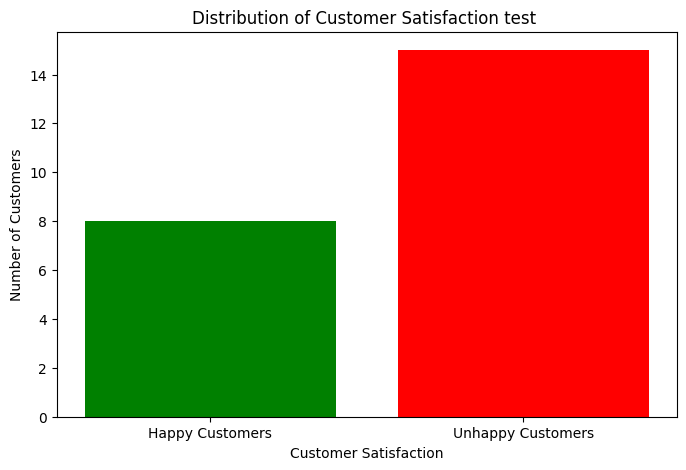

In [42]:
# calculating the happy and unhappy customers
predictions = grid_search_rf.predict(x_test)
# Count the occurrences of each class
happy_count = np.sum(predictions == 1)
unhappy_count = np.sum(predictions == 0)
# Creating a bar chart to visualize the number of happy and unhappy customers
labels = ['Happy Customers', 'Unhappy Customers']
counts = [happy_count, unhappy_count]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Customer Satisfaction')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Satisfaction test ')
plt.show()

# finding which features are more important when predicting a customer’s happiness
after training the model we calculate the most important features which affect on our cutomer happines and it seems:
- the first one was the app satisfaction which mean "the app makes ordering easy for me"
- the second one was price satisfaction which mean "I paid a good price for my order"
- the last one was the delivery time which mean " my order was delivered on time"

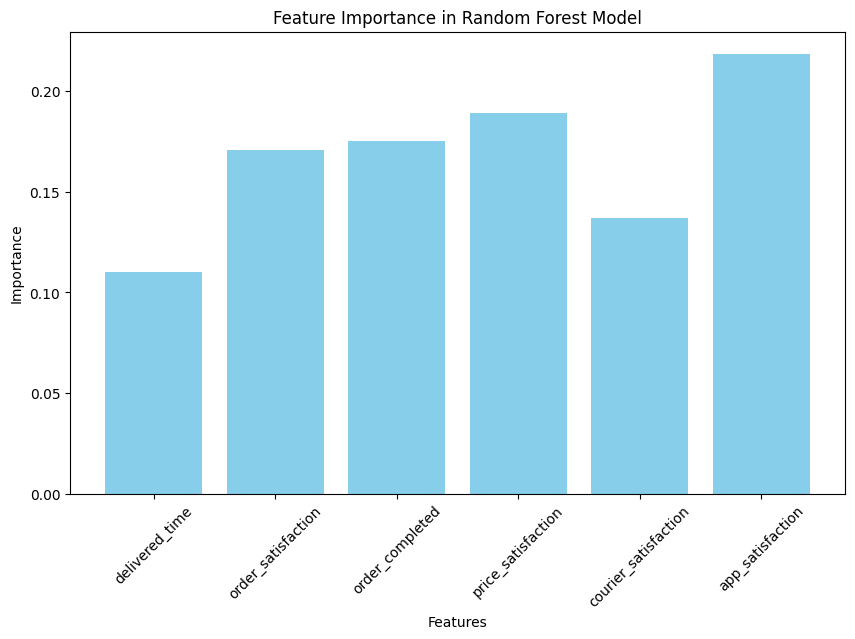

In [39]:
# Get feature importances
best_rf_model = grid_search_rf.best_estimator_

# Get feature importances from the best model
feature_importances = best_rf_model.feature_importances_

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(x.columns, feature_importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.xticks(rotation=45)
plt.show()